<a href="https://colab.research.google.com/github/SGRGit/gwOsc/blob/master/CreateSampleSignalProc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import scipy

In [0]:
import matplotlib.pyplot as plt

In [0]:
import numpy as np

#Fs = 1e3;  # sampling rate
#Ts = 1.0/Fs; # sampling interval
#t = np.arange(0,1, Ts) # time vector

fs = 1e4
fr = np.float(50.0)
N = 1e3
fr = 100.0
t = np.arange(N) / fs

#t = np.linspace(0, 60, 50)
#a = 1e-18
a = 5
x = a*np.sin(2*np.pi*fr*t) + a*np.cos(2*np.pi*fr*t)
n = 1e2*np.random.randn(len(t))
xn = x + np.random.randn(len(t))

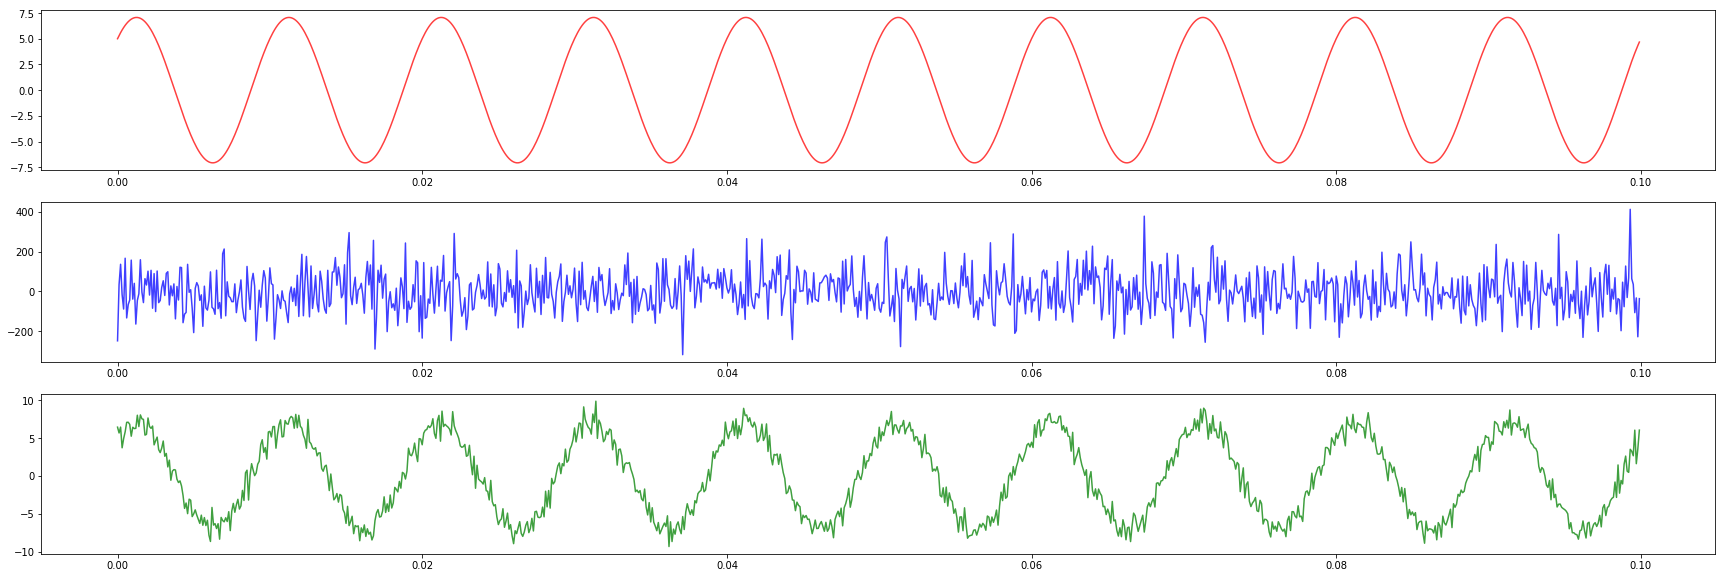

In [49]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1)
f.set_figwidth(30)
f.set_figheight(10)
ax1.plot(t, x, 'r' , alpha=0.75)

ax2.plot(t, n, 'b', alpha=0.75)

ax3.plot(t, xn, 'g', alpha=0.75)


[(1, 2000)]

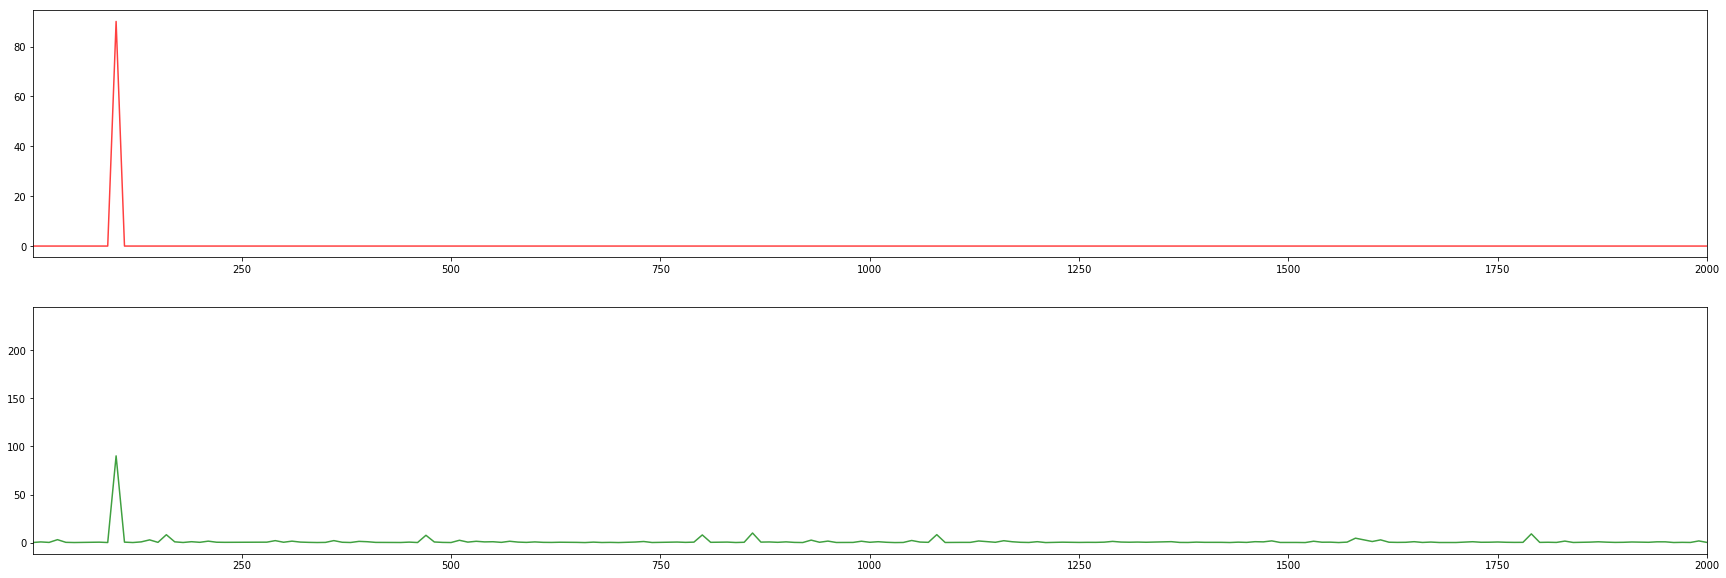

In [50]:
#noise + signal
s = len(xn) 
k = np.arange(s)
T = s/fs
frq = k/T # two sides frequency range
frq = frq[range(int(s/2))] # one side frequency range
Y = np.fft.fft(xn)/n # fft computing and normalization
Y = Y[range(int(s/2))]

# signal
ss = len(x) 
ks = np.arange(ss)
Ts = ss/fs
frqs = ks/T # two sides frequency range
frqs = frq[range(int(ss/2))] # one side frequency range
Ys = np.fft.fft(x)/n # fft computing and normalization
Ys = Ys[range(int(ss/2))]


#plt.plot(frq, abs(Y))

ft, (axft1, axft2) = plt.subplots(2, 1)
ft.set_figwidth(30)
ft.set_figheight(10)
axft1.plot(frqs, abs(Ys), 'r' , alpha=0.75)
axft2.plot(frq, abs(Y), 'g', alpha=0.75)
axft1.axes.set(xlim = (1, 2000))
axft2.axes.set(xlim = (1, 2000))

# Feature Extraction

In [0]:
# %load ./../functions/detect_peaks.py
"""Detect peaks in data based on their amplitude and other features."""

from __future__ import division, print_function

def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):
    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
        if mph is not None:
            mph = -mph
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
            if mph is not None:
                mph = -mph
        _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind


def _plot(x, mph, mpd, threshold, edge, valley, ax, ind):
    """Plot results of the detect_peaks function, see its help."""
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(30, 10))

        ax.plot(x, 'b', lw=1)
        if ind.size:
            label = 'valley' if valley else 'peak'
            label = label + 's' if ind.size > 1 else label
            ax.plot(ind, x[ind], '+', mfc=None, mec='r', mew=2, ms=8,
                    label='%d %s' % (ind.size, label))
            ax.legend(loc='best', framealpha=.5, numpoints=1)
        ax.set_xlim(-.02*x.size, x.size*1.02-1)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax.set_xlabel('Data #', fontsize=14)
        ax.set_ylabel('Amplitude', fontsize=14)
        mode = 'Valley detection' if valley else 'Peak detection'
        ax.set_title("%s (mph=%s, mpd=%d, threshold=%s, edge='%s')"
                     % (mode, str(mph), mpd, str(threshold), edge))
        
        # plt.grid()
        plt.show()

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.insert(1, r'./../functions')  # add to pythonpath

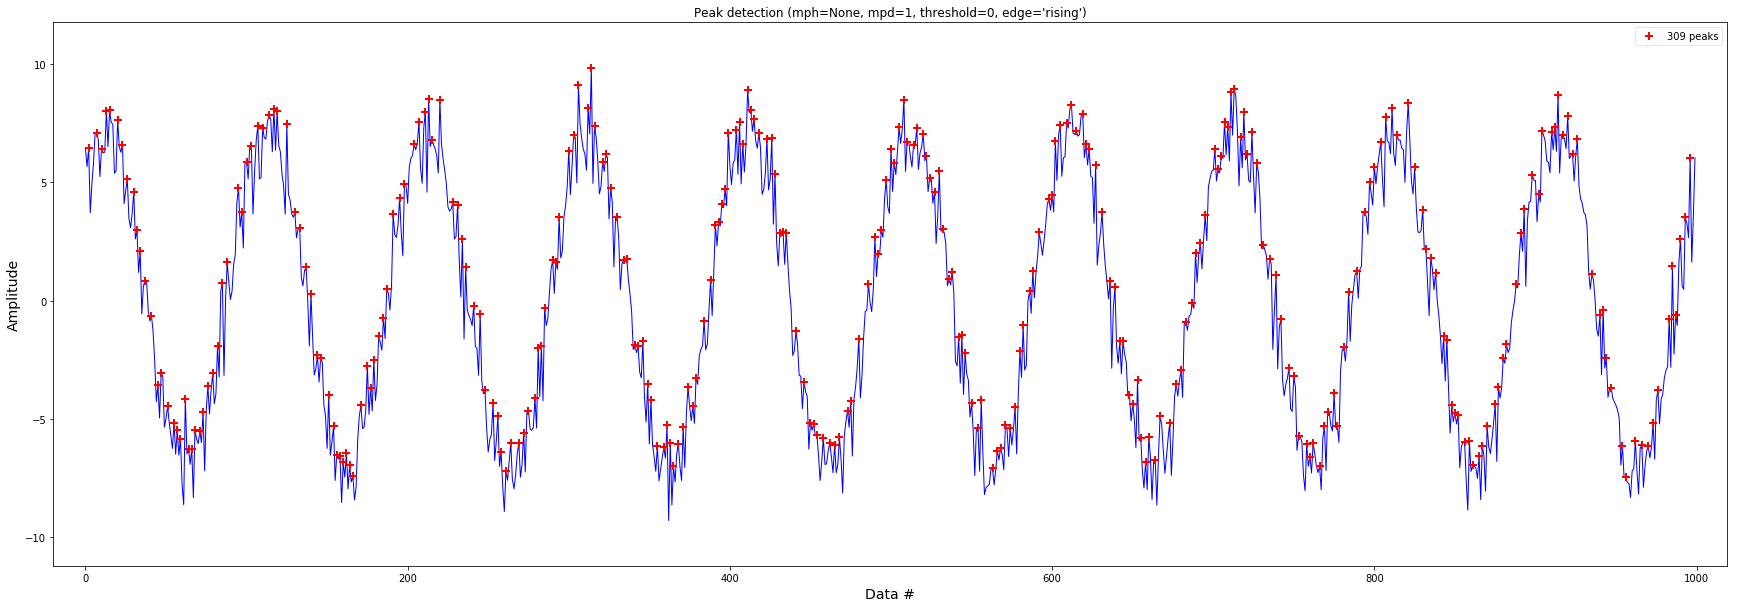

In [53]:
ind = detect_peaks(xn, show=True)

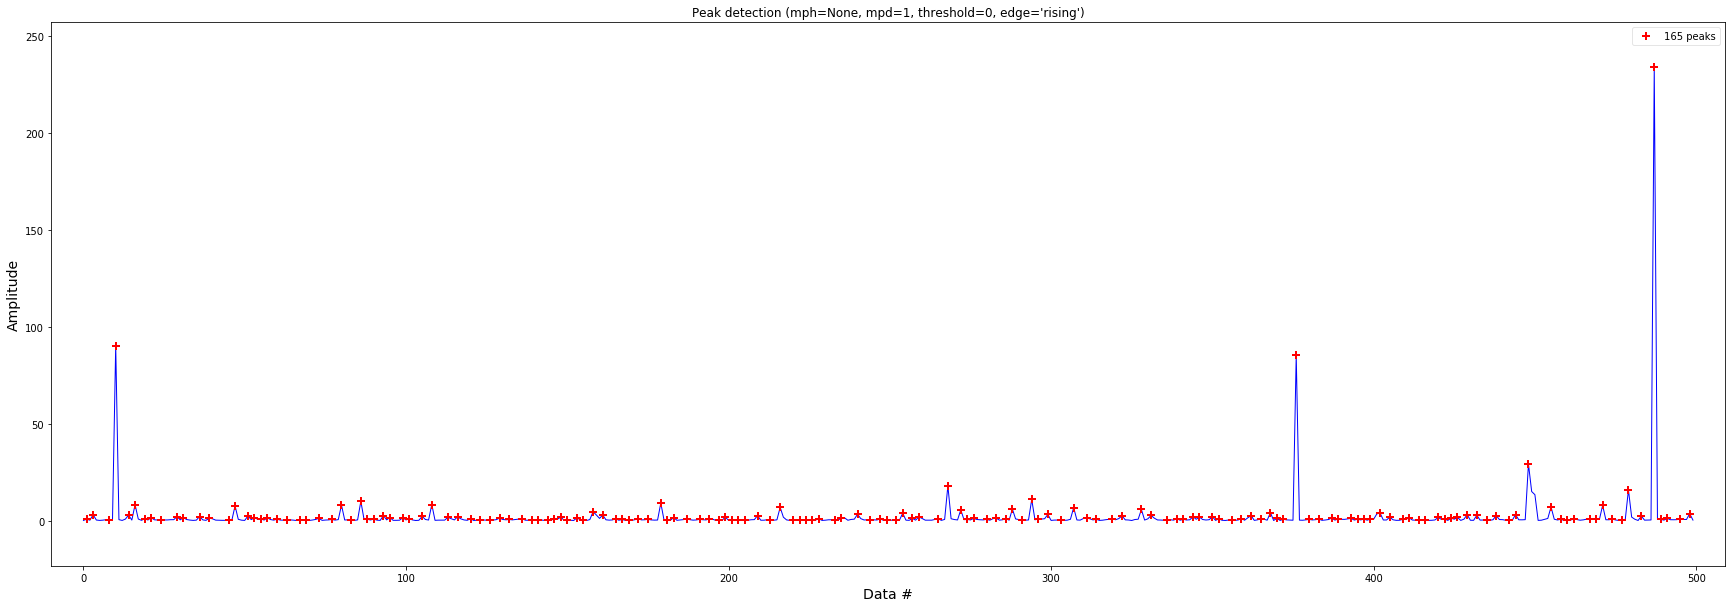

In [54]:
indfft = detect_peaks(abs(Y), show=True)